## Machine Learning Classifaction
1. Support Vector Machine SVM

One of the advantages of sVM is that it is very effective in high dimensional spaces. 

We will not use PCA on the training sets to reduce the number of dimensions for SVM.

In [29]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
#The Background Dataset
background = pd.read_csv('./datasets/training/background-giants.csv')
background = background.query('PhotoZ > -9999')
background_id = background[['objID', 'ra', 'dec']]

#Dropping the irrelevant features for training SVM model.
background = background.drop(['objID','objID1','ra','dec'], axis=1)
background.head()

,psfMag_u0,psfMag_g0,psfMag_r0,psfMag_i0,psfMag_z0,fiberMag_u0,fiberMag_g0,fiberMag_r0,fiberMag_i0,fiberMag_z0,...,fracDeV_g,fracDeV_r,fracDeV_i,fracDeV_z,dered_u,dered_g,dered_r,dered_i,dered_z,PhotoZ
0,21.08928,19.37086,18.25864,17.81117,17.51476,21.25800,19.36015,18.24822,17.80149,17.45830,...,1.000000,1.000000,1.000000,1.000000,20.13362,18.32410,17.19614,16.74197,16.40898,0.163294
1,21.41094,19.66853,19.04671,18.49730,18.12082,21.32957,19.64395,18.69971,18.21872,17.81517,...,0.048899,0.111197,0.102860,0.200284,18.94811,17.26758,16.39990,15.94577,15.60334,0.079898
2,21.27979,19.46498,18.33810,17.92343,17.63418,21.25036,19.44884,18.34415,17.88955,17.55409,...,1.000000,1.000000,1.000000,1.000000,20.15441,18.22609,17.11155,16.65807,16.33635,0.158405
3,20.79575,18.89698,17.82768,17.38629,17.21747,20.79277,18.79881,17.79642,17.37555,17.02053,...,0.930281,0.932025,0.997685,1.000000,19.56097,17.58059,16.57519,16.14223,15.82258,0.119085
4,19.69155,17.76127,16.98154,16.55225,16.24577,19.77281,17.82529,16.89516,16.47335,16.13554,...,0.916555,0.941605,0.954829,0.975430,18.35271,16.36183,15.47458,15.03607,14.70395,0.059261


In [31]:
#The Foreground Dataset
foreground = pd.read_csv('./datasets/training/foreground-dwarfs.csv')
foreground_id = foreground[['objID', 'ra', 'dec']]

#Droping the unuseful objID that comes with CrossID
foreground = foreground.drop(['objID','objID1','ra','dec'], axis=1)
foreground.head()

,psfMag_u0,psfMag_g0,psfMag_r0,psfMag_i0,psfMag_z0,fiberMag_u0,fiberMag_g0,fiberMag_r0,fiberMag_i0,fiberMag_z0,...,fracDeV_g,fracDeV_r,fracDeV_i,fracDeV_z,dered_u,dered_g,dered_r,dered_i,dered_z,PhotoZ
0,20.68459,20.32490,19.90491,19.65816,19.58863,20.93056,19.84648,19.39435,19.13173,18.93974,...,0.000000,0.000000,0.000000,0.024766,17.14250,16.04856,15.63828,15.42416,15.29288,0.025635
1,20.38590,18.79545,18.40734,18.01583,17.85035,20.31682,18.76537,18.05824,17.72758,17.45851,...,0.252313,0.271305,0.262290,0.388589,18.42509,16.79932,16.11763,15.77143,15.49772,0.043808
2,20.37486,19.15429,18.46381,18.16368,18.04567,20.36893,18.84602,18.14171,17.79829,17.57360,...,0.199078,0.165721,0.215467,0.192362,18.37703,16.79943,16.09405,15.74896,15.51344,0.044954
3,20.10566,18.50956,17.90357,17.60673,17.37036,20.09557,18.56411,17.81530,17.47781,17.24816,...,0.726548,0.861712,0.876894,0.829082,17.90406,16.35933,15.61268,15.26653,15.02099,0.059635
4,20.55464,18.93523,18.13289,17.79406,17.84563,20.42518,18.61701,17.89809,17.54489,17.28442,...,0.357629,0.358013,0.392165,0.397820,18.33514,16.66942,15.94401,15.56867,15.34149,0.054202


In [32]:
# Keep concatenated id when for later merge
galaxies_id = pd.concat([foreground_id,background_id])
galaxies_id.head()

,objID,ra,dec
0,1237680311772250464,16.765005,32.389555
1,1237680315521237319,16.792826,32.346872
2,1237680311772250198,16.685466,32.418586
3,1237680315521302864,16.966691,32.256108
4,1237680311772381486,17.066149,32.499011


In [33]:
galaxies_id.shape[0]

573

In [34]:
# In this case the label for background is 0 and foreground will be 1.
foreground['label'] = 1
background['label'] = 0

In [35]:
# The foreground and background sets now have to be concated together and have the label column removed as a seperate 
# array to perform SVM.
galaxies = pd.concat([foreground,background])
galaxies.head()

,psfMag_u0,psfMag_g0,psfMag_r0,psfMag_i0,psfMag_z0,fiberMag_u0,fiberMag_g0,fiberMag_r0,fiberMag_i0,fiberMag_z0,...,fracDeV_r,fracDeV_i,fracDeV_z,dered_u,dered_g,dered_r,dered_i,dered_z,PhotoZ,label
0,20.68459,20.32490,19.90491,19.65816,19.58863,20.93056,19.84648,19.39435,19.13173,18.93974,...,0.000000,0.000000,0.024766,17.14250,16.04856,15.63828,15.42416,15.29288,0.025635,1
1,20.38590,18.79545,18.40734,18.01583,17.85035,20.31682,18.76537,18.05824,17.72758,17.45851,...,0.271305,0.262290,0.388589,18.42509,16.79932,16.11763,15.77143,15.49772,0.043808,1
2,20.37486,19.15429,18.46381,18.16368,18.04567,20.36893,18.84602,18.14171,17.79829,17.57360,...,0.165721,0.215467,0.192362,18.37703,16.79943,16.09405,15.74896,15.51344,0.044954,1
3,20.10566,18.50956,17.90357,17.60673,17.37036,20.09557,18.56411,17.81530,17.47781,17.24816,...,0.861712,0.876894,0.829082,17.90406,16.35933,15.61268,15.26653,15.02099,0.059635,1
4,20.55464,18.93523,18.13289,17.79406,17.84563,20.42518,18.61701,17.89809,17.54489,17.28442,...,0.358013,0.392165,0.397820,18.33514,16.66942,15.94401,15.56867,15.34149,0.054202,1


### All Features
Training ML model on all features of the dataset.

In [36]:
# SVM parameter tuning using GridSearchCV
def svc_param_selection(X, y):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1, 10]
    nfolds = 5
    param_grid = {'C': Cs, 'gamma': gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    return grid_search.best_params_

In [37]:
#The two seperate array used in SVM to construct a predicting model
X = galaxies.drop('label',1)
y = galaxies['label']

In [38]:
# Cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, y_train.shape

((458, 136), (458,))

In [39]:
X_test.shape, y_test.shape

((115, 136), (115,))

In [40]:
svc_param_selection(X, y)

{'C': 1, 'gamma': 0.001}

In [41]:
# Using the default kernel type which is a Gaussian
clf = svm.SVC(C=1, gamma=0.001)
# Fitting the model and it can now be used to predict labels if we feed it a dataframe with the same columns
clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.84 (+/- 0.26)


In [42]:
# Using sigmoid kernel
sigmoidModel = svm.SVC(C=1, gamma=0.001, kernel='sigmoid')
sigmoidModel.fit(X_train, y_train)
scores = cross_val_score(sigmoidModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.50 (+/- 0.15)


In [43]:
# Using polynomial kernel of different degrees
polyModel = svm.SVC(C=1, gamma=0.001, kernel='poly', degree=1)
polyModel.fit(X_train, y_train)
scores = cross_val_score(polyModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.90 (+/- 0.09)


In [44]:
polyModel = svm.SVC(C=1, gamma=0.001, kernel='poly', degree=2)
polyModel.fit(X_train, y_train)
scores = cross_val_score(polyModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.90 (+/- 0.16)


In [45]:
#polyModel = svm.SVC(C=1, gamma=0.001, kernel='poly', degree=3)
#polyModel.fit(X_train, y_train)
#scores = cross_val_score(polyModel, X_test, y_test, cv=5)
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

### Feature Engineering
https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

We want to improve the ML model by performing some feature engineering:
1. Univariate Selection
2. Feature Importance
3. Correlation Matrix with Heatmap

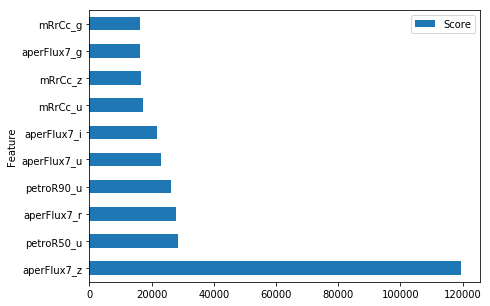

In [46]:
# Univariate selection can be used to select those features that have the strongest relationship with the output 
# variable.
X = galaxies.drop(['label'], axis=1) # Independent columns
X = X.abs() # Removing negative values
y = galaxies['label'] # Target column, galaxy type

# Applying SelectKBest to extract top 10 best features
best_features = SelectKBest(score_func=chi2, k=10)
fit = best_features.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
features_scores = pd.concat([dfcolumns, dfscores], axis=1) # Concatenate dataframes for better visualization
features_scores.columns = ['Feature', 'Score'] # Naming dataframe columns
features_scores.nlargest(10, 'Score').plot(x='Feature', y='Score', kind='barh', figsize=(7, 5))
plt.show()
# print(features_scores.nlargest(10, 'Score')) # Print 10 best features

/Users/danrachou/Documents/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


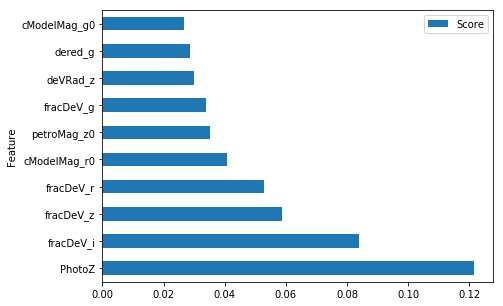

In [51]:
# Feature importance gives you a score for each feature of your data, the higher the score more important or relevant
# is the feature towards your output variable.
X = galaxies.drop(['label'], axis=1) # Independent columns
y = galaxies['label'] # Target column, galaxy type
model = ExtraTreesClassifier()
model.fit(X, y)

# Plot graph of feature importances to for better visualization
# feature_importances_ is a inbuilt class
#feat_importances = pd.Series(model.feature_importances_, index=X.columns)
dfscores = pd.DataFrame(model.feature_importances_)
dfcolumns = pd.DataFrame(X.columns)
feat_importances = pd.concat([dfcolumns, dfscores], axis=1)
feat_importances.columns = ['Feature', 'Score']
feat_importances.nlargest(10, 'Score').plot(x='Feature', y='Score', kind='barh', figsize=(7, 5))
plt.show()

In [52]:
# Features for heatmap:
features = pd.concat([features_scores.nlargest(10, 'Score'), feat_importances.nlargest(10, 'Score')])
features = features.sort_values('Feature')
features['Feature']

135          PhotoZ
121     aperFlux7_g
123     aperFlux7_i
122     aperFlux7_r
120     aperFlux7_u
124     aperFlux7_z
116    cModelMag_g0
117    cModelMag_r0
89         deVRad_z
131         dered_g
126       fracDeV_g
128       fracDeV_i
127       fracDeV_r
129       fracDeV_z
56          mRrCc_g
55          mRrCc_u
59          mRrCc_z
19      petroMag_z0
25       petroR50_u
30       petroR90_u
Name: Feature, dtype: object

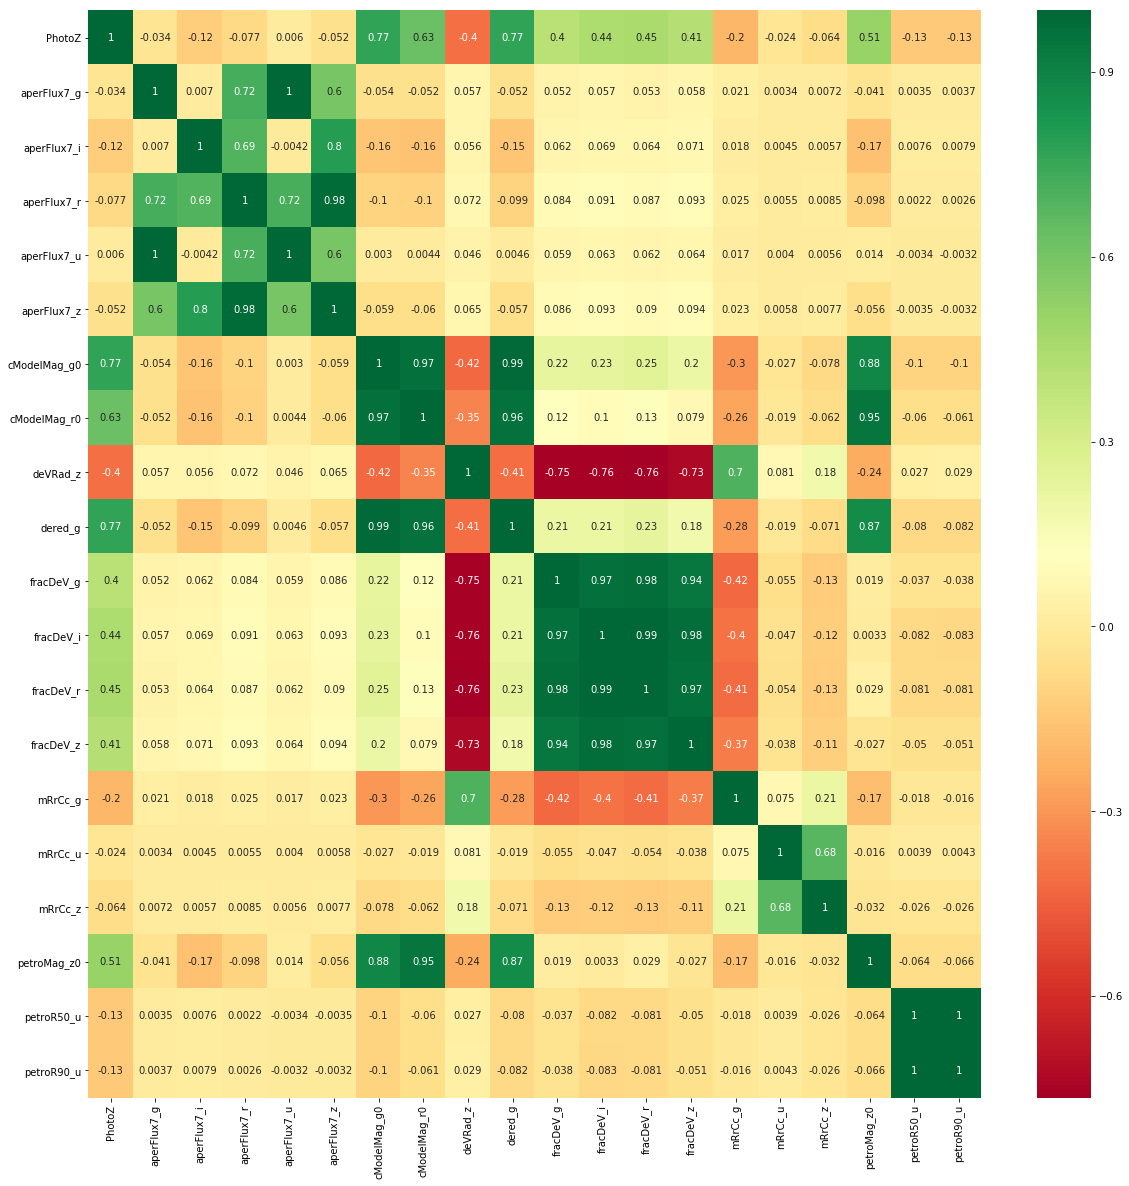

In [53]:
# Correlation Matrix with Heatmap
corrmat = galaxies[features['Feature']].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(galaxies[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### 10 Best Features and 10 Most Important Features
Training the model on 10 of the best scoring features and 10 of most important features.

In [54]:
X = galaxies[features['Feature']]
y = galaxies['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, y_train.shape

((458, 20), (458,))

In [55]:
X_test.shape, y_test.shape

((115, 20), (115,))

In [56]:
svc_param_selection(X, y)

{'C': 1, 'gamma': 0.001}

In [57]:
clf = svm.SVC(C=1, gamma=0.001)
clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.87 (+/- 0.27)


We see accuracy improvement of 0.03% of the Gaussian kernel after some feature engineering.

In [58]:
# Using sigmoid kernel
sigmoidModel = svm.SVC(C=1, gamma=0.001, kernel='sigmoid')
sigmoidModel.fit(X_train, y_train)
scores = cross_val_score(sigmoidModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.49 (+/- 0.37)


In [59]:
# Using polynomial kernel of different degrees
polyModel = svm.SVC(C=1, gamma=0.001, kernel='poly', degree=1)
polyModel.fit(X_train, y_train)
scores = cross_val_score(polyModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.87 (+/- 0.06)


In [60]:
polyModel = svm.SVC(C=1, gamma=0.001, kernel='poly', degree=2)
polyModel.fit(X_train, y_train)
scores = cross_val_score(polyModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.89 (+/- 0.10)


In [61]:
# Takes a really long time...
#polyModel = svm.SVC(C=1, gamma=0.001, kernel='poly', degree=3)
#polyModel.fit(X_train, y_train)
#scores = cross_val_score(polyModel, X_test, y_test, cv=5)
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

### 10 Best Features
Training the ML model on the 5 best features gives the same accuracy score as training the moddel on the 10 best features.

In [62]:
X = galaxies[features_scores.nlargest(10, 'Score')['Feature']]
y = galaxies['label']

In [63]:
# Cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, y_train.shape

((458, 10), (458,))

In [64]:
X_test.shape, y_test.shape

((115, 10), (115,))

In [65]:
svc_param_selection(X, y)

{'C': 1, 'gamma': 0.001}

In [66]:
clf = svm.SVC(C=1, gamma=0.001)
clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.87 (+/- 0.27)


In [67]:
# Using sigmoid kernel
sigmoidModel = svm.SVC(C=1, gamma=0.001, kernel='sigmoid')
sigmoidModel.fit(X_train, y_train)
scores = cross_val_score(sigmoidModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.49 (+/- 0.37)


In [68]:
# Using polynomial kernel of different degrees
polyModel = svm.SVC(C=1, gamma=0.001, kernel='poly', degree=1)
polyModel.fit(X_train, y_train)
scores = cross_val_score(polyModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.87 (+/- 0.11)


In [69]:
polyModel = svm.SVC(C=1, gamma=0.001, kernel='poly', degree=2)
polyModel.fit(X_train, y_train)
scores = cross_val_score(polyModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.87 (+/- 0.13)


### 10 Most Important Features

In [70]:
X = galaxies[feat_importances.nlargest(10, 'Score')['Feature']]
y = galaxies['label']

In [71]:
# Cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, y_train.shape

((458, 10), (458,))

In [72]:
X_test.shape, y_test.shape

((115, 10), (115,))

In [73]:
svc_param_selection(X, y)

{'C': 10, 'gamma': 0.1}

In [74]:
clf = svm.SVC(C=10, gamma=0.1)
clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.91 (+/- 0.15)


In [75]:
# Using sigmoid kernel
sigmoidModel = svm.SVC(C=10, gamma=0.1, kernel='sigmoid')
sigmoidModel.fit(X_train, y_train)
scores = cross_val_score(sigmoidModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.66 (+/- 0.02)


In [76]:
# Using polynomial kernel of different degrees
polyModel = svm.SVC(C=10, gamma=0.1, kernel='poly', degree=1)
polyModel.fit(X_train, y_train)
scores = cross_val_score(polyModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.93 (+/- 0.16)


In [77]:
polyModel = svm.SVC(C=10, gamma=0.1, kernel='poly', degree=2)
polyModel.fit(X_train, y_train)
scores = cross_val_score(polyModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.94 (+/- 0.09)


### 20 Most Important Features

In [78]:
X = galaxies[feat_importances.nlargest(20, 'Score')['Feature']]
y = galaxies['label']

In [79]:
# Cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, y_train.shape

((458, 20), (458,))

In [80]:
X_test.shape, y_test.shape

((115, 20), (115,))

In [81]:
svc_param_selection(X, y)

{'C': 10, 'gamma': 0.001}

In [82]:
clf = svm.SVC(C=10, gamma=0.001)
clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.87 (+/- 0.18)


In [83]:
# Using sigmoid kernel
sigmoidModel = svm.SVC(C=10, gamma=0.001, kernel='sigmoid')
sigmoidModel.fit(X_train, y_train)
scores = cross_val_score(sigmoidModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.66 (+/- 0.02)


In [84]:
# Using polynomial kernel of different degrees
polyModel = svm.SVC(C=10, gamma=0.001, kernel='poly', degree=1)
polyModel.fit(X_train, y_train)
scores = cross_val_score(polyModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.90 (+/- 0.12)


In [85]:
polyModel = svm.SVC(C=10, gamma=0.001, kernel='poly', degree=2)
polyModel.fit(X_train, y_train)
scores = cross_val_score(polyModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.94 (+/- 0.07)


In [86]:
polyModel = svm.SVC(C=10, gamma=0.001, kernel='poly', degree=3)
polyModel.fit(X_train, y_train)
scores = cross_val_score(polyModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.87 (+/- 0.17)


In [87]:
print(feat_importances.nlargest(20, 'Score')['Feature'])

135          PhotoZ
128       fracDeV_i
129       fracDeV_z
127       fracDeV_r
117    cModelMag_r0
19      petroMag_z0
126       fracDeV_g
89         deVRad_z
131         dered_g
116    cModelMag_g0
132         dered_r
13     fiber2Mag_i0
66         mE1PSF_g
11     fiber2Mag_g0
111       expMag_g0
8       fiberMag_i0
5       fiberMag_u0
110       expMag_u0
18      petroMag_i0
122     aperFlux7_r
Name: Feature, dtype: object


In [70]:
#We now grab the test data which is the Perseus cluster csv file retrieved from SDSS
#base_test = pd.read_csv('./datasets/test/perseus.csv')

#Strip all the unusefull data and format it to be usefull in SDSS CrossID
#cross_id_test = base_test

#Export formated file to be used in SDSS CrossID
#cross_id_test.to_csv(r'./machine-learning-sets/testData_crossID.csv', index=False)

#After doing CrossID, importing the Testing Dataset
#test_Data = pd.read_csv('./machine-learning-sets/testData_crossID.csv')

#Droping the unuseful objID that comes with CrossID
#test_Data = test_Data.drop(['ra','dec'], axis=1)

#test_Data.head()

In [71]:
#Time for the predict, remember that 1 means foreground and 0 means background
#clf = model.predict(test_Data)
#scores = cross_val_score(clf, iris.data, iris.target, cv=5)
#print('Number of foregrounds with gauss kernel: {}'.format(np.count_nonzero(clf == 1)))
#print('Number of backgrounds with gauss kernel: {}'.format(np.count_nonzero(clf == 0)))

In [72]:
#Iteration of the model using the sigmoid kernel rather than the rbf gaussian one
#sigmoidModel = svm.SVC(gamma='auto', kernel='sigmoid')
#sigmoidModel.fit(samples,labels)
#sigResults = sigmoidModel.predict(test_Data)
#print('Number of foregrounds with sigmoid kernel: {}'.format(np.count_nonzero(sigResults == 1)))
#print('Number of backgrounds with sigmoid kernel: {}'.format(np.count_nonzero(sigResults == 0)))

In [73]:
#Iteration of the model using a polynomial kernel of degree, d
#d = 5
#for n in range(1,d+1):
#    polyModel = svm.SVC(gamma='auto', kernel='poly', degree=n)
#    polyModel.fit(samples,labels)
#    polyResults = polyModel.predict(test_Data)
#    print('Number of foregrounds with poly kernel at degree {}: {}'.format(n,np.count_nonzero(polyResults == 1)))
#    print('Number of backgrounds with poly kernel degree {}: {}'.format(n,np.count_nonzero(polyResults == 0)))
#    print('----------------------------------------------------------------------------------------------------')